Resource: https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets
Purpose: 2025 Spring Capstone PNC time series analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import json
import seaborn as sns

In [3]:
# Load data
card_data = pd.read_csv("/Users/m/Desktop/2025 Spring/Capstone/PNC_timeseries/cards_data.csv")
transactions = pd.read_csv("/Users/m/Desktop/2025 Spring/Capstone/PNC_timeseries/transactions_data.csv")
users_data = pd.read_csv("/Users/m/Desktop/2025 Spring/Capstone/PNC_timeseries/users_data.csv")

In [4]:
with open("/Users/m/Desktop/2025 Spring/Capstone/PNC_timeseries/mcc_codes.json", "r") as f:
    mcc_codes = json.load(f)

with open("/Users/m/Desktop/2025 Spring/Capstone/PNC_timeseries/train_fraud_labels.json", "r") as f:
    train_fraud_labels = json.load(f)


In [33]:
# Data type check and adjust
users_data['per_capita_income'] = users_data['per_capita_income'].replace({'\$': ''}, regex = True).astype(int)
users_data['yearly_income'] = users_data['yearly_income'].replace({'\$': ''}, regex = True).astype(int)
users_data['total_debt'] = users_data['total_debt'].replace({'\$': ''}, regex = True).astype(int)

EDA 
1. Explore users characteristics in the User_data
2. Explore transaction data
    1. Fraud ratio detection, anormal users detect
    2. Transaction frequency check


<AxesSubplot:xlabel='credit_score', ylabel='Count'>

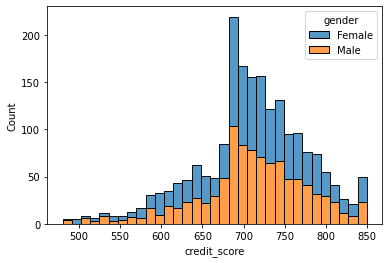

In [37]:
sns.histplot(data = users_data, x = 'credit_score', hue = 'gender', multiple = 'stack')

<AxesSubplot:xlabel='num_credit_cards', ylabel='Count'>

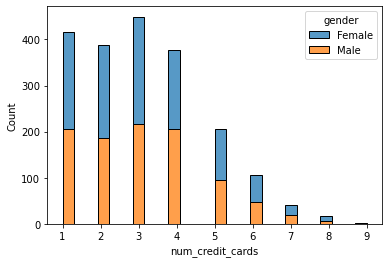

In [38]:
sns.histplot(data = users_data, x = 'num_credit_cards', hue = 'gender', multiple = 'stack')

<AxesSubplot:xlabel='current_age', ylabel='Count'>

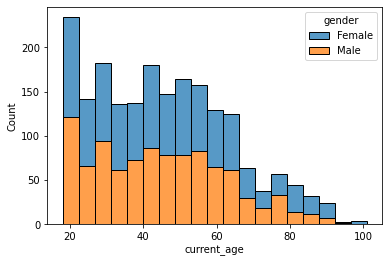

In [36]:
sns.histplot(data = users_data, x = 'current_age', hue = 'gender', multiple = 'stack')

<AxesSubplot:xlabel='yearly_income', ylabel='Count'>

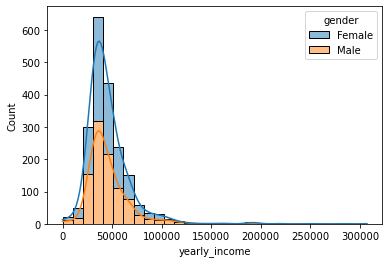

In [42]:
sns.histplot(data = users_data, x = 'yearly_income', hue = 'gender', multiple = 'stack', bins = 30, kde=True)

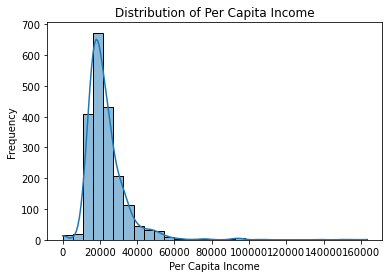

In [44]:
# Distribution of per capita income
sns.histplot(users_data['per_capita_income'], kde=True, bins=30)
plt.xlabel("Per Capita Income")
plt.ylabel("Frequency")
plt.title("Distribution of Per Capita Income")
plt.show()

<AxesSubplot:xlabel='total_debt', ylabel='Count'>

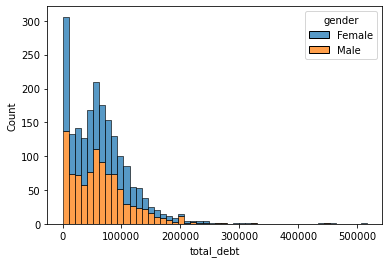

In [43]:
sns.histplot(data = users_data, x = 'total_debt', hue = 'gender', multiple = 'stack')


In [49]:
transactions.dtypes

id                  int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
label              object
dtype: object

In [51]:
from pyspark.sql import SparkSession, functions as F

# Create or get your SparkSession
spark = SparkSession.builder.appName("ClientTransactionsAggregation").getOrCreate()

transactions_pyspark = spark.createDataFrame(transactions)

# Assuming your DataFrame is already loaded as 'df'
# If the date column is not in date format, convert it:
transactions_pyspark = transactions_pyspark.withColumn("date", F.to_date("date"))

# Extract the year from the date column:
transactions_pyspark = transactions_pyspark.withColumn("year", F.year("date"))

# Compute the total transactions per client over all years:
total_transactions_df = transactions.groupBy("client_id").agg(
    F.count("*").alias("total_transactions")
)

# # If you know the list of ten years (for example, 2010 to 2019), you can provide it:
# years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

# # Pivot the data to get number of transactions per client for each year:
# yearly_transactions_df = transactions.groupBy("client_id") \
#     .pivot("year", years) \
#     .agg(F.count("*"))

# # Join the total transactions with the yearly transactions:
# transaction_number = total_transactions_df.join(yearly_transactions_df, on="client_id", how="left")

# # To display the result
# # transaction_number.show(truncate=False)


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.readRDDFromFile.
: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.api.java.JavaRDD$.readRDDFromInputStream(JavaRDD.scala:252)
	at org.apache.spark.api.java.JavaRDD$.readRDDFromFile(JavaRDD.scala:239)
	at org.apache.spark.api.python.PythonRDD$.readRDDFromFile(PythonRDD.scala:289)
	at org.apache.spark.api.python.PythonRDD.readRDDFromFile(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.runWith(Thread.java:1596)
	at java.base/java.lang.Thread.run(Thread.java:1583)


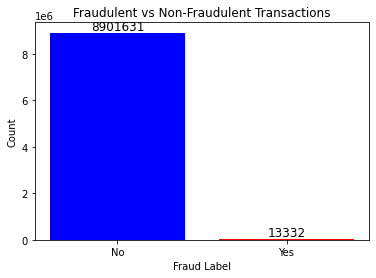

In [ ]:
# Check Fraud ratio detection

# Extract labels
labels = list(train_fraud_labels["target"].values())

# Count occurrences of 'Yes' and 'No'
label_counts = Counter(labels)

# Plot bar chart
plt.figure(figsize=(6, 4))

bars = plt.bar(label_counts.keys(), label_counts.values(), color=['blue', 'red'])
# Add text labels on each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(int(height)), ha='center', va='bottom', fontsize=12)

plt.xlabel("Fraud Label")
plt.ylabel("Count")
plt.title("Fraudulent vs Non-Fraudulent Transactions")


plt.show()

In [6]:
# Check users who have fraud trasections

# check number of clients in each database
print('number of clinet in users_data: ', users_data['id'].nunique())
print('number of client in cards_data: ', card_data["client_id"].nunique())
print('number of client in transactions: ', transactions["client_id"].nunique())


labels_dict = train_fraud_labels["target"] # Extract the dictionary from JSON
# Map the label using dictionary to transactions data
transactions["label"] = transactions["id"].astype(str).map(labels_dict)

# Display the updated DataFrame
print(transactions.head())


number of clinet in users_data:  2000
number of client in cards_data:  2000
number of client in transactions:  1219
        id                 date  client_id  card_id   amount  \
0  7475327  2010-01-01 00:01:00       1556     2972  $-77.00   
1  7475328  2010-01-01 00:02:00        561     4575   $14.57   
2  7475329  2010-01-01 00:02:00       1129      102   $80.00   
3  7475331  2010-01-01 00:05:00        430     2860  $200.00   
4  7475332  2010-01-01 00:06:00        848     3915   $46.41   

            use_chip  merchant_id merchant_city merchant_state      zip   mcc  \
0  Swipe Transaction        59935        Beulah             ND  58523.0  5499   
1  Swipe Transaction        67570    Bettendorf             IA  52722.0  5311   
2  Swipe Transaction        27092         Vista             CA  92084.0  4829   
3  Swipe Transaction        27092   Crown Point             IN  46307.0  4829   
4  Swipe Transaction        13051       Harwood             MD  20776.0  5813   

  errors lab

In [7]:
# Count the number of NaN values in 'label' column
num_test_observations = transactions['label'].isna().sum()

print(f"Number of test observations: {num_test_observations}")

Number of test observations: 4390952


In [8]:
# Test set: where 'label' is NaN
test_set = transactions[transactions['label'].isna()].copy()

# Training set: where 'label' is NOT NaN
train_set = transactions[transactions['label'].notna()].copy()


print('percentage of test: ', round(test_set.shape[0] / (train_set.shape[0] + train_set.shape[0]), 4))

# Display the counts
print(f"Training Set: {train_set.shape[0]} rows")
print(f"Test Set: {test_set.shape[0]} rows")

percentage of test:  0.2463
Training Set: 8914963 rows
Test Set: 4390952 rows


In [10]:
train_set["merchant_id"].nunique()

66537

In [46]:
# Check high income clients(defined as per capita income >= 60,000) fraud transection

high_income_threshold = 100000
high_income_clients = list(users_data[users_data["yearly_income"] >= high_income_threshold]["id"])
print('number of high income clients:', len(high_income_clients))
print('high income clients id:', high_income_clients)
high_income_clients_transection = train_set[train_set['client_id'].isin(high_income_clients)]
sum(high_income_clients_transection["label"] == 'No')
print('number of fraud transections from high income clients', sum(high_income_clients_transection["label"] == 'Yes'))
print('ratio of fraud transections from high income clients', sum(high_income_clients_transection["label"] == 'Yes')/sum(high_income_clients_transection["label"] == 'No'))

number of high income clients: 52
high income clients id: [708, 1164, 777, 1452, 1014, 290, 165, 1799, 1427, 1147, 1625, 1543, 995, 1897, 1201, 236, 1156, 599, 1223, 1865, 715, 842, 763, 704, 1259, 856, 115, 1426, 1600, 453, 341, 440, 1517, 696, 944, 342, 1079, 700, 1988, 414, 952, 959, 1692, 278, 1648, 1325, 989, 1983, 1168, 1790, 1395, 628]
number of fraud transections from high income clients 359
ratio of fraud transections from high income clients 0.0011994734345034046


In [ ]:
# Transection frenquence 

2. Client Segmentation (Clustering)
Objective:

Group clients into small clusters that exhibit similar payment behavior patterns.
Steps:

Feature Selection:
Choose features that represent client behavior (e.g., average transaction amount, transaction frequency, seasonality metrics, volatility).
Clustering Algorithm:
Use algorithms like K-means, DBSCAN, or hierarchical clustering.
Consider dimensionality reduction techniques (e.g., PCA) if you have a large number of features.
Validation:
Validate clusters using internal metrics (e.g., silhouette score) and domain expertise to ensure that each group is distinct and interpretable.


3. Time Series Anomaly Detection Within Each Cluster
Objective:

Develop separate time series models for each cluster to capture normal payment behaviors and detect anomalies.
Steps:

Model Selection:
Depending on data granularity and complexity, consider statistical models (ARIMA, exponential smoothing), machine learning approaches (Random Forest for time series), or deep learning methods (LSTM, Prophet).
Model Training:
Train the model on historical transaction time series data for each cluster.
Ensure models capture trends, seasonality, and cyclic behavior specific to the group.
Anomaly Detection:
Define a threshold for what constitutes an anomaly (e.g., deviations beyond a certain confidence interval or prediction error threshold).
Flag transactions or periods where actual behavior deviates significantly from the model’s predictions.
Evaluation:
Use historical data with known anomalies (if available) or synthetic anomalies to evaluate detection performance.
Iterate on model tuning and threshold settings.


4. Collaborative Filtering for New Customer Payment Range Prediction
Objective:

Predict a “reasonable” payment range for new customers based on similar clients.
Steps:

Data Preparation:
Use historical payment behavior and cluster information from existing clients.
Collaborative Filtering Setup:
Choose an appropriate collaborative filtering approach:
User-based: Find existing clients similar to the new customer based on initial features or early behavior.
Item-based (or Payment-based): Identify patterns in payment behaviors across similar clients.
Model Training:
Train the collaborative filtering model using transaction history (e.g., matrix factorization techniques such as SVD or neighborhood-based methods).
Incorporate the cluster information as an additional feature to refine similarity calculations.
Prediction:
For a new client, the system should recommend a reasonable payment range based on the aggregated behavior of similar clients.
Evaluation:
Validate the collaborative filtering recommendations against historical cases where the actual payment ranges are known.
Adjust model parameters as needed.


5. Integration and Monitoring
Workflow Integration:

Combine the anomaly detection and collaborative filtering modules into a unified system.
Create dashboards or alerting mechanisms for detected anomalies and for visualizing the recommended payment ranges for new customers.
Feedback Loop:

Set up processes to gather feedback from domain experts (e.g., fraud analysts, risk managers) on flagged anomalies and recommendations.
Use this feedback to retrain or fine-tune your models periodically.
Monitoring & Maintenance:

Implement model monitoring to track performance over time.
Schedule regular retraining sessions as more data become available and as client behavior evolves.
